In [1]:
# import general libraries
import numpy as np
from scipy.signal import periodogram
from scipy.signal import welch
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from matplotlib.ticker import FuncFormatter
# import from the file multiplayer_prisoners_dilemma.py
from multiplayer_prisoners_dilemma import QLearningAgent
from multiplayer_prisoners_dilemma import Game
from multiplayer_prisoners_dilemma import Simulation

# game parameters
num_players = 2
action_space = np.array([0 ,  1], dtype=float) # (0 = cooperate, 1 = defect)
observation_length = 0 # number of previous actions that are considered in the observation vector (0 = only current action)
use_prefactor = False

Plot_just_simualtion = False

In [2]:
class DeterministicAgent():
    def __init__(self, Q_values_initial, learning_rate, discount_factor, temperature):
        self.Q_values_initial = Q_values_initial
        self.Q_values = Q_values_initial
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.temperature = temperature
        self.Q_values_history = []         # history of Q-values
        self.prob_vector_history = []        # history of probabilities

    def get_prob_vector(self):
        return np.exp(self.Q_values / self.temperature) / np.sum(np.exp(self.Q_values / self.temperature))
    
    def update_history(self):
        self.Q_values_history.append(self.Q_values)
        self.prob_vector_history.append(self.get_prob_vector())

    def reset(self):
        self.Q_values = self.Q_values_initial

class DeterministicBatchAgent():
    def __init__(self, Q_values_initial, learning_rate, discount_factor, temperature):
        self.Q_values_initial = Q_values_initial
        self.Q_values = Q_values_initial

        self.prob_vector_initial = np.exp(self.Q_values_initial / temperature) / np.sum(np.exp(self.Q_values_initial / temperature))
        self.prob_vector = self.prob_vector_initial

        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.temperature = temperature

        self.Q_values_history = []         # history of Q-values
        self.prob_vector_history = []        # history of probabilities

    def get_prob_vector(self):
        return self.prob_vector
    
    def update_history(self):
        self.Q_values_history.append(self.Q_values)
        self.prob_vector_history.append(self.get_prob_vector())

    def reset(self):
        self.Q_values = self.Q_values_initial
        self.prob_vector = self.prob_vector_initial

def Q_step(agents, reward_matrices):
    '''Deterministic Q-learning step for a symmetric 2x2 repeated normal-form game for two agents'''
    # update history
    for agent in agents:
        agent.update_history()

    # get the probability vector of the agents
    agent_1, agent_2 = agents
    prob_vector_agent_1 = agent_1.get_prob_vector()
    prob_vector_agent_2 = agent_2.get_prob_vector()

    # get the reward matrices
    reward_matrix_A, reward_matrix_B = reward_matrices
    
    # update the Q-values via deterministic equation
    Q_vector_new_1 = agent_1.Q_values + agent_1.learning_rate * prob_vector_agent_1 * (reward_matrix_A @ prob_vector_agent_2 + agent_1.discount_factor * np.max(agent_1.Q_values) - agent_1.Q_values)
    Q_vector_new_2 = agent_2.Q_values + agent_2.learning_rate * prob_vector_agent_2 * (prob_vector_agent_1 @ reward_matrix_B + agent_2.discount_factor * np.max(agent_2.Q_values) - agent_2.Q_values)

    # update the Q-values
    agent_1.Q_values = Q_vector_new_1
    agent_2.Q_values = Q_vector_new_2

def deterministic_batch_Q_step(agents, reward_matrices):
    # update history
    for agent in agents:
        agent.update_history()

    # get the probability vector of the agents
    agent_1, agent_2 = agents
    prob_vector_agent_1 = agent_1.get_prob_vector()
    prob_vector_agent_2 = agent_2.get_prob_vector()

    # get the reward matrices
    reward_matrix_A, reward_matrix_B = reward_matrices
    
    # update the Q-values via deterministic equation
    prob_vector_new_1 = ( prob_vector_agent_1 * np.exp(agent_1.learning_rate * (reward_matrix_A @ prob_vector_agent_2 - agent_1.temperature * np.log(prob_vector_agent_1))) ) / np.sum( prob_vector_agent_1 * np.exp(agent_1.learning_rate * (reward_matrix_A @ prob_vector_agent_2 - agent_1.temperature * np.log(prob_vector_agent_1)) ) )
    prob_vector_new_2 = ( prob_vector_agent_2 * np.exp(agent_2.learning_rate * (prob_vector_agent_1 @ reward_matrix_B - agent_2.temperature * np.log(prob_vector_agent_2))) ) / np.sum( prob_vector_agent_2 * np.exp(agent_2.learning_rate * (prob_vector_agent_1 @ reward_matrix_B - agent_2.temperature * np.log(prob_vector_agent_2)) ) )

    # update the Q-values
    agent_1.prob_vector = prob_vector_new_1
    agent_2.prob_vector = prob_vector_new_2

def generate_q_values(prob_to_coop, temperature, base_value):
    # Calculate the difference between Q-values
    delta_Q = temperature * np.log(1/prob_to_coop - 1) # difference between Q-values: delta_Q = Q_D - Q_C
    
    # Calculate Q_D and Q_C centered around the base value
    Q_D = base_value + delta_Q / 2
    Q_C = base_value - delta_Q / 2
    
    return np.array([Q_C, Q_D])

# define the reward function for the two player prisoner's dilemma
def reward_matrix_for_two_player_PD(action_vector, player_id):
    action_tuple = tuple(action_vector)
    S, P, R, T = 0, 1, 3, 5
    #S, P, R, T = -44.05, -41.04, 3.01, 6.37
    reward_matrix = {
            (0, 0): (R, R),  # Both cooperate
            (0, 1): (S, T),  # Agent A cooperates, agent B defects
            (1, 0): (T, S),  # Agent A defects, agent B cooperates
            (1, 1): (P, P),  # Both defect
        }
    reward = reward_matrix[action_tuple]
    return reward[player_id]

# Extract the individual reward matrices for the two player games individually for vectorized calculations
def get_individual_matrices(reward_function):
    # extract the individual reward matrices
    reward_matrix_A = np.array([[reward_function([0, 0], 0), reward_function([0, 1], 0)],
                                [reward_function([1, 0], 0), reward_function([1, 1], 0)]])
    reward_matrix_B = np.array([[reward_function([0, 0], 1), reward_function([0, 1], 1)],
                                [reward_function([1, 0], 1), reward_function([1, 1], 1)]])
    
    if reward_function == reward_matrix_for_two_player_PD:
        game_title = 'Prisoner\'s Dilemma'
        first_action_title = 'Cooperation'
    elif reward_function == reward_matrix_for_two_player_MP:
        game_title = 'Matching Pennies'
        first_action_title = 'Heads'
    elif reward_function == reward_matrix_for_two_player_SH:
        game_title = 'Stag Hunt'
        first_action_title = 'Stag'
    elif reward_function == reward_matrix_for_two_player_BS:
        game_title = 'Bach or Stravinsky'
        first_action_title = 'Bach'

    return [reward_matrix_A, reward_matrix_B], game_title, first_action_title

# define the function that calculates the fixed point policy for the prisoner's dilemma
def calculate_fixed_point_policy(temperature, discount_factor, initial_guess = [0, 1], print_solution = True, print_additional_info = False):
    # define four-dimensional system of equations
    def equations(variables, T = temperature, discount_factor = discount_factor):
        a, b, c, d = variables

        eq1 = a - 1 / (np.exp(c/T) + np.exp(d/T)) * (3 * np.exp(c/T)) +\
            discount_factor * max(a,b)
        eq2 = b - 1 / (np.exp(c/T) + np.exp(d/T)) * (5 * np.exp(c/T) + np.exp(d/T)) +\
            discount_factor * max(a,b)
        eq3 = c - 1 / (np.exp(a/T) + np.exp(b/T)) * (3 * np.exp(a/T)) +\
            discount_factor * max(c,d)
        eq4 = d - 1 / (np.exp(a/T) + np.exp(b/T)) * (5 * np.exp(a/T) + np.exp(b/T)) +\
            discount_factor * max(c,d)

        return [eq1, eq2, eq3, eq4]

    # Initial guess for the solution
    a_init, b_init = initial_guess
    initial_guess = [a_init, b_init, a_init, b_init]

    # Solve the system numerically and get information
    result, infodict, ier, msg = fsolve(equations, initial_guess, full_output=True)
    a, b, c, d = result
    fixed_point_policy = np.exp(a/temperature) / (np.exp(a/temperature) + np.exp(b/temperature))

    # prints
    if print_solution:
        print("------------------------------------")
        print(f"Numerical Solution: Q^1_C = {a}, Q^1_D = {b}, Q^2_C = {c}, Q^2_D = {d}")
        print("Q^1_D - Q^1_C =", b - a)
        print(f"Fixed point policy at T={temperature} : ", fixed_point_policy)
        print("------------------------------------")
        print()


    if print_additional_info:
        # Additional information about the solution process
        print("\nSolution Process Information:")
        print("Number of iterations:", infodict['nfev'])
        print("fjac\n", infodict['fjac'])
        print("fvec\n", infodict['fvec'])
        print("r", infodict['r'])
        print("qtf", infodict['qtf'])
        print("Exit code:", ier)
        print("Exit message:", msg)

        # Zustandssumme: 
        N1 = np.exp(result[0]) + np.exp(result[1])
        N2 = np.exp(result[2]) + np.exp(result[3])
        print()
        print("Zustandssumme:")
        print("N1 =", N1)
        print("N2 =", N2)

        # Wahrscheinlichkeiten:
        print("Wahrscheinlichkeiten:")
        print("p1 =", np.exp(result[0]) / N1)
        print("p2 =", np.exp(result[1]) / N1)

    return fixed_point_policy

# define the function that calculates the Q target values for a given opponents policy for the prisoner's dilemma
def calculate_target_Q_values(prob_to_coop_j, discount_factor, print_solution = False):
    # expected rewards for agent i
    Exp_Reward_C = 3 * prob_to_coop_j + 0 * (1. - prob_to_coop_j)
    Exp_Reward_D = 5 * prob_to_coop_j + 1 * (1. - prob_to_coop_j)

    # geometric series for agent i
    Q_max_C = Exp_Reward_C / (1 - discount_factor)
    Q_max_D = Exp_Reward_D / (1 - discount_factor)

    # target Q-values for agent j
    Q_target_C = Exp_Reward_C + discount_factor * max(Q_max_C, Q_max_D)
    Q_target_D = Exp_Reward_D + discount_factor * max(Q_max_C, Q_max_D)

    if print_solution:
        print("------------------------------------")
        print(f"For prob_to_coop_j = {prob_to_coop_j} and discount_factor = {discount_factor}, the target Q-values are:")
        print(f"Q_target_C = {Q_target_C}")
        print(f"Q_target_D = {Q_target_D}")
        print("------------------------------------")
        print()

    return np.array([Q_target_C, Q_target_D])

# write a function that calculates the eigenvalues and eigenvectors of the Jacobi matrix for the Prisoner's Dilemma
def calculate_eigenvalues_and_eigenvectors(discount_factor, temperature, learning_rate, print_solution = False):  
    # calculate the fixed point policy and the target Q-values
    fixed_point_policy = calculate_fixed_point_policy(temperature, discount_factor, print_solution = False)
    Q_target_C, Q_target_D = calculate_target_Q_values(fixed_point_policy, discount_factor, print_solution = False)

    def p(a, b):
        return np.exp(a/temperature) / (np.exp(a/temperature) + np.exp(b/temperature))

    def partial_p(a, b):
        return np.exp((a+b)/temperature) / ( temperature * (np.exp(a/temperature) + np.exp(b/temperature))**2 )

    def f(a, b, c, d):
        return learning_rate * partial_p(a, b) * ( 3 * p(c, d) + discount_factor * b - a)

    def g(a, b, c, d):
        return 3 * learning_rate * p(a,b) * partial_p(c, d)

    def h(a, b, c, d):
        return learning_rate * partial_p(a, b) * ( 4 * p(c, d) + 1 + (discount_factor - 1) * b)

    def i(a, b, c, d):
        return 4 * learning_rate * (1 - p(a,b)) * partial_p(c, d)

    a, b, c, d = Q_target_C, Q_target_D, Q_target_C, Q_target_D

    # define the Jacobi matrix entries
    if True:
        j_11 = + f(a,b,c,d) - learning_rate * p(a, b) + 1
        j_12 = - f(a,b,c,d) + learning_rate * discount_factor * p(a, b)
        j_13 = + g(a,b,c,d)
        j_14 = - g(a,b,c,d)

        j_21 = - h(a,b,c,d)
        j_22 = + h(a,b,c,d) + learning_rate * (discount_factor - 1) * (1 - p(a, b)) + 1
        j_23 = + i(a,b,c,d)
        j_24 = - i(a,b,c,d)

        j_31 = + g(c,d,a,b)
        j_32 = - g(c,d,a,b)
        j_33 = + f(c,d,a,b) - learning_rate * p(c, d) + 1
        j_34 = - f(c,d,a,b) + learning_rate * discount_factor * p(c, d)

        j_41 = + i(c,d,a,b)
        j_42 = - i(c,d,a,b)
        j_43 = - h(c,d,a,b)
        j_44 = + h(c,d,a,b) + learning_rate * (discount_factor - 1) * (1 - p(c, d)) + 1

    # Define the 4x4 Jacobi matrix 
    J = np.array([[j_11, j_12, j_13, j_14],
                [j_21, j_22, j_23, j_24],
                [j_31, j_32, j_33, j_34],
                [j_41, j_42, j_43, j_44]])

    # Calculate eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(J)
    eigenvalues_betrag = np.abs(eigenvalues)

    # Print the results
    if print_solution:
        print(f"gamma = {discount_factor}")
        print()
        for i in range(len(eigenvalues)):
            print(f"Eigenvalue {i+1}:", eigenvalues[i])
        print()
        for i in range(len(eigenvalues_betrag)):
            print(f"Absolute Eigenvalue {i+1}:", eigenvalues_betrag[i])
        print()
    
    return eigenvalues, eigenvectors

def generate_q_values(prob_to_coop, temperature, base_value):
    # Calculate the difference between Q-values
    delta_Q = temperature * np.log(1/prob_to_coop - 1) # difference between Q-values: delta_Q = Q_D - Q_C
    
    # Calculate Q_D and Q_C centered around the base value
    Q_D = base_value + delta_Q / 2
    Q_C = base_value - delta_Q / 2
    
    return np.array([[Q_C, Q_D]])

In [3]:
# define the agents
agent_pair = [QLearningAgent, QLearningAgent]
discount_factor = 0.
learning_rate = 0.01
selection_method = "Boltzmann" 
temperature = 1
#initial_q_tables = [np.array([[0.69314718, -0.69314718]], dtype=float) for i in range(num_players)]
initial_probability_pair = (0.9, 0.7)
base_value = 0
initial_q_tables = [generate_q_values(prob, temperature, base_value) for prob in initial_probability_pair]
print("Initial Q-Tables:")
print(initial_q_tables)

# Create a list of agents
agents = [agent_pair[i](player_id = i, 
                action_space = action_space,
                num_players = num_players,
                discount_factor = discount_factor,
                observation_length = observation_length,
                selection_method = selection_method,
                reward_func = reward_matrix_for_two_player_PD,
                temperature = temperature,
                learning_rate = learning_rate,
                q_table = initial_q_tables[i],
                use_prefactor = use_prefactor
                )       
                for i in range(num_players)]

# Create a game and a Simulation
game = Game(agents = agents)
simulation = Simulation()

# length of the time series
if discount_factor == 0.: # if discount factor is 0, 3e3 time steps are enough
    num_time_steps = int(3e3)
    round_length = 1
elif discount_factor == 0.8: # if discount factor is 0.8, 1e5 time steps are necessary
    num_time_steps = int(1e5)
    round_length = 0
else:
    num_time_steps = int(1e4)
# number of runs
num_runs = 1
for run in range(num_runs):
    simulation.run(game, agents, num_time_steps)
    # get probabilities
    probabilities_agents = [] 
    for agent in agents:
        prob_to_coop = np.array([agent.get_action_probabilities(q_table) for q_table in agent.q_table_history[:]])[:, 0, 0] # Extract the first entry of each 2D array
        probabilities_agents.append(prob_to_coop)

Initial Q-Tables:
[array([[ 1.09861229, -1.09861229]]), array([[ 0.42364893, -0.42364893]])]


In [4]:
import os
directory = os.path.join("data", "TimeEvolution")
if False:
    # make directory to store the data for reproducibility of the results if not already existing
    # use .join() to make the code platform independent
    if not os.path.exists(directory):
        os.makedirs(directory)
    # save the Q_table histories and the probabilities in files
    np.save(os.path.join(directory, f"Q_table_histories_p_initial_{initial_probability_pair}_T_{temperature}_learningRate_{learning_rate}_y_{discount_factor}.npy"), [agent.q_table_history for agent in agents])
    np.save(os.path.join(directory, f"probabilities_p_initial_{initial_probability_pair}_T_{temperature}_learningRate_{learning_rate}_y_{discount_factor}.npy"), probabilities_agents)

In [5]:
# Deterministic Q-learning agents
def generate_q_values_for_deterministic_agents(prob_to_coop, temperature, base_value):
    # Calculate the difference between Q-values
    delta_Q = temperature * np.log(1/prob_to_coop - 1) # difference between Q-values: delta_Q = Q_D - Q_C
    
    # Calculate Q_D and Q_C centered around the base value
    Q_D = base_value + delta_Q / 2
    Q_C = base_value - delta_Q / 2
    
    return np.array([Q_C, Q_D]) # it uses the structure [Q_C, Q_D] instead of [[Q_C, Q_D]] !

agent_pair = [DeterministicBatchAgent, DeterministicBatchAgent]
initial_q_tables_deterministic_agents = [generate_q_values_for_deterministic_agents(prob, temperature, base_value) for prob in initial_probability_pair]
agents_batch = [agent_pair[i](Q_values_initial = initial_q_tables_deterministic_agents[i],
                                       learning_rate=learning_rate, 
                                       discount_factor=discount_factor, 
                                       temperature=temperature) 
                                       for i in range(num_players)]

reward_matrices, game_title, first_action_title = get_individual_matrices(reward_matrix_for_two_player_PD)
for t in range(num_time_steps):
    deterministic_batch_Q_step(agents_batch, reward_matrices)

# get the histories of probabilities to cooperate for each agent 
n = 1 # plot only every n-th time step to reduce the number of lines
prob_coop_of_agent_batch_1_list = [vector[0] for vector in agents_batch[0].prob_vector_history[::n]]
prob_coop_of_agent_batch_2_list = [vector[0] for vector in agents_batch[1].prob_vector_history[::n]]

initial_probability_pair = (0.9, 0.7)
3000


/var/folders/m0/6bzh86rj63g58k6l_qqv_3z80000gn/T/ipykernel_23651/962081108.py:66: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x156fcc4c0>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  ax[2].legend(handles=handles, labels=labels, loc=loc, fontsize=fontsize, ncol=2)
/var/folders/m0/6bzh86rj63g58k6l_qqv_3z80000gn/T/ipykernel_23651/962081108.py:66: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x156fcc790>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  ax[2].legend(handles=handles, labels=labels, loc=loc, fontsize=fontsize, ncol=2)
/var/folders/m0/6bzh86rj63g58k6l_qqv_3z80000gn/T/ipykernel_23651/962081108.py:66: UserWarning: Legend does not support [<matplotlib.lines.Line2D object 

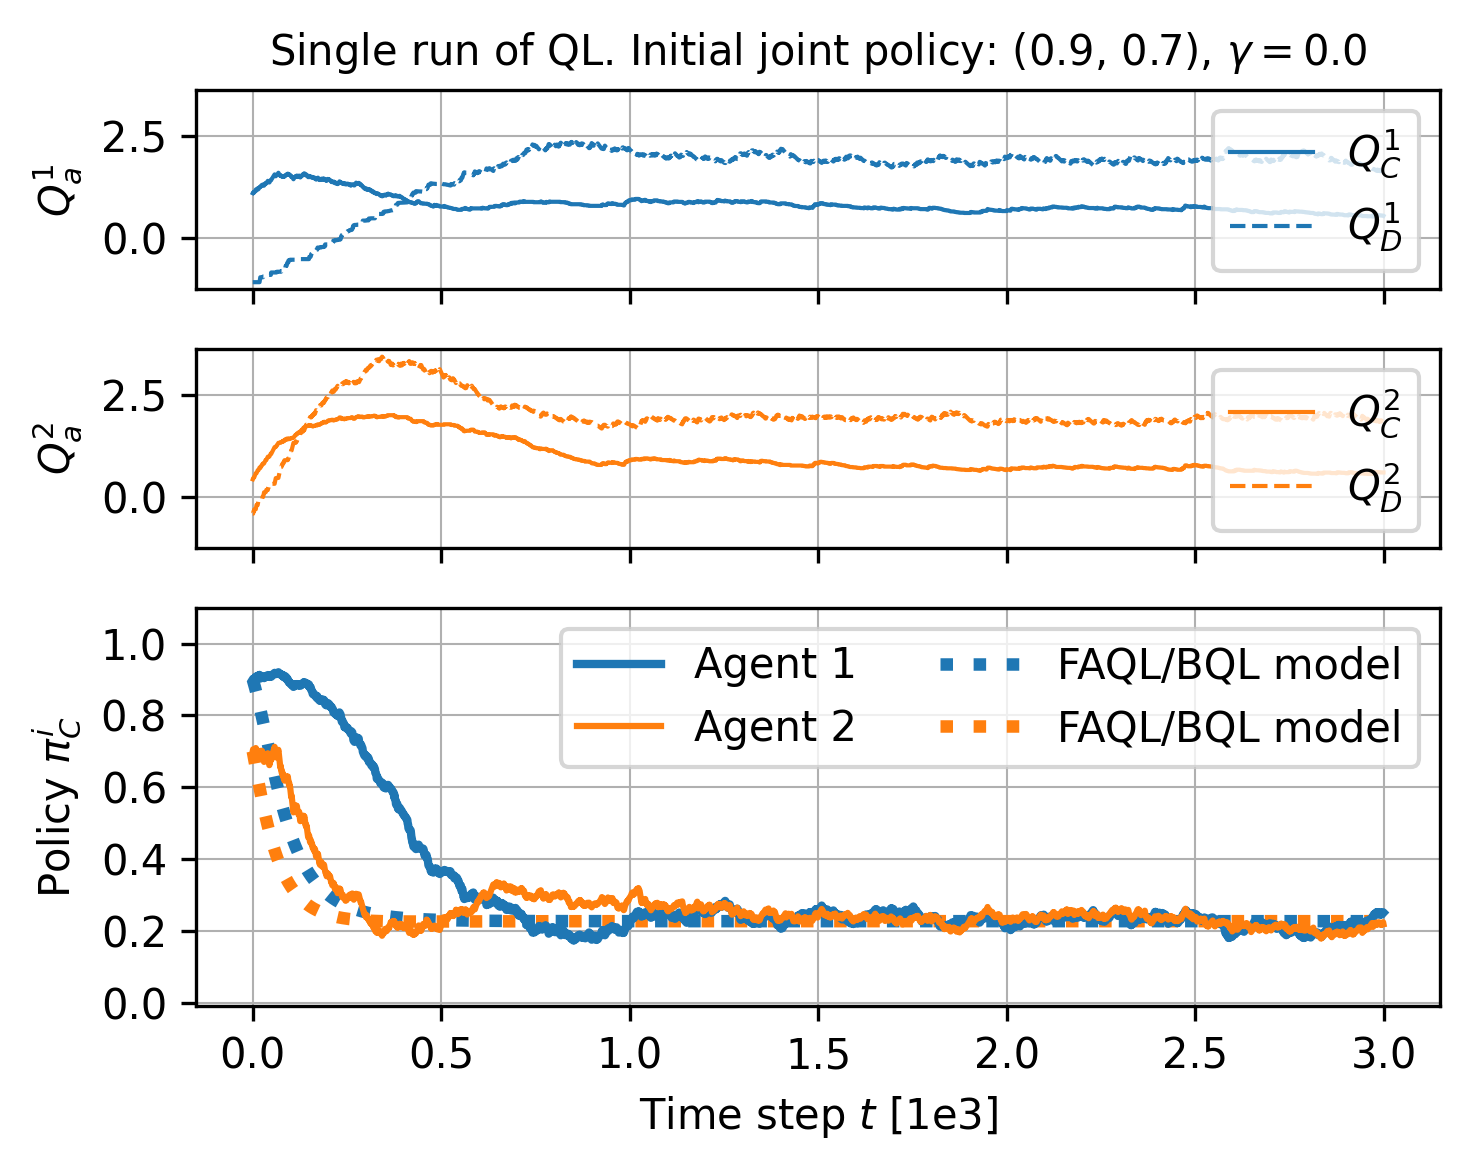

In [6]:
# FIGURE A
# plot Q-values over time
figsize=(5, 4)
fontsize = None
dpi=300
color1 = 'C0'
color2 = 'C1'
color_array = [color1, color2]
fig, ax = plt.subplots(3, 1, figsize=figsize, dpi=dpi, sharex=True, gridspec_kw={'height_ratios': [1, 1, 2]})

# decide where to put the legend
loc="upper right"

# load the Q_table histories and the probabilities from files
load_histories = True
if load_histories:
    discount_factor = 0.
    initial_probability_pair = (0.9, 0.7)
    print(f"initial_probability_pair = {initial_probability_pair}")
    if initial_probability_pair == (0.9, 0.7) and discount_factor == 0.8:
        loc="center" # change the location of the legend for the (0.9, 0.7) case where gamma = 0.8
    q_table_histories = np.load( os.path.join(directory, f"Q_table_histories_p_initial_{initial_probability_pair}_T_{temperature}_learningRate_{learning_rate}_y_{discount_factor}.npy"), allow_pickle=True)
    probabilities_agents = np.load( os.path.join(directory, f"probabilities_p_initial_{initial_probability_pair}_T_{temperature}_learningRate_{learning_rate}_y_{discount_factor}.npy"), allow_pickle=True)
    for i, agent in enumerate(agents):
        agent.q_table_history = q_table_histories[i]

if initial_probability_pair == (0.9, 0.7) and load_histories and discount_factor == 0.8:
    max_time_steps = int(2.1e6)
else:
    max_time_steps = len(probabilities_agents[0]) - 1 # -1 because the first entry is the initial probability
print(max_time_steps)

for i, agent in enumerate(agents):
    q_values_C = [q_table[0, 0] for q_table in agent.q_table_history[:max_time_steps]]
    q_values_D = [q_table[0, 1] for q_table in agent.q_table_history[:max_time_steps]]
    ax[i].plot(q_values_C, label=f'$Q^{i+1}_C$', color=color_array[i], linestyle='-', linewidth=1)
    ax[i].plot(q_values_D, label=f'$Q^{i+1}_D$', color=color_array[i], linestyle='--', linewidth=1)
    ax[i].set_ylabel(f'$Q^{i+1}'+r'_{a}$', fontsize=fontsize)
    #ax[i].set_ylim(-1.5, 1.5)
    ax[i].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[i].grid(linestyle='-', linewidth=0.5)
    ax[i].legend(loc=loc, fontsize=fontsize)

# identify which range is larger
y_range_0 = ax[0].get_ylim()
y_range_1 = ax[1].get_ylim()
# get the minimum and the maximum
y_range = [min(y_range_0[0], y_range_1[0]), max(y_range_0[1], y_range_1[1])]
for i in range(2):
    ax[i].set_ylim(y_range)

# FIGURE B
# plot probabilities over time
handle1 = ax[2].plot(probabilities_agents[0][:max_time_steps], label=f'Agent 1', color=color1, linewidth=2, zorder=10)
handle2 = ax[2].plot(probabilities_agents[1][:max_time_steps], label=f'Agent 2', color=color2, zorder=10)
if Plot_just_simualtion:
    ax[2].legend(loc=loc, fontsize=fontsize, ncol=1)
    # title
    ax[0].set_title(f'Single run of QL. Initial joint policy: {initial_probability_pair}', fontsize=fontsize)
if not Plot_just_simualtion:
    # plot deterministic probabilities over time
    handle3 = plt.plot(prob_coop_of_agent_batch_1_list, color=color1, linewidth=3, linestyle=':', label='FAQL/BQL model', zorder=5)
    handle4 = plt.plot(prob_coop_of_agent_batch_2_list, color=color2, linewidth=3, linestyle=':', label='FAQL/BQL model', zorder=5)
    handles = [handle1, handle2, handle3, handle4]
    labels = ['Agent 1', 'Agent 2', 'BQL model', 'BQL model']
    ax[2].legend(handles=handles, labels=labels, loc=loc, fontsize=fontsize, ncol=2)
    # title
    #ax[0].set_title(f'Initial joint policy: {initial_probability_pair}, $\gamma = {discount_factor}$', fontsize=fontsize)
    ax[0].set_title(f'Single run of QL. Initial joint policy: {initial_probability_pair}, $\gamma = {discount_factor}$', fontsize=fontsize)


# Define a custom formatter to scale the x-axis labels by 1e3
def scientific_formatter(x, pos):
    return f'{x / 1e3:.{round_length}f}'
# Set the custom formatter for the x-axis
ax[2].xaxis.set_major_formatter(FuncFormatter(scientific_formatter))
# set labels
ax[2].set_xlabel('Time step $t$ [1e3]', fontsize=fontsize)
ax[2].set_ylabel(f'Policy $\pi^i_C$', fontsize=fontsize)

# fix the y-axis to the range
if initial_probability_pair == (0.5, 0.5) or initial_probability_pair == (0.5, 0.48):
    ax[2].set_ylim(-0.01, 0.61)
else:
    ax[2].set_ylim(-0.01, 1.1)
    ax[2].set_yticks(np.arange(0, 1.2, 0.2))

#caption = (f'$\gamma$ = {discount_factor}, '+r'$Q_{base}$ = '+f'{base_value}')
#fig.text(0.5, -0.05, caption, wrap=True, horizontalalignment='center', fontsize=fontsize)
if Plot_just_simualtion:
    ncol = 1
else: 
    ncol = 2
ax[2].legend(loc=loc, fontsize=fontsize, ncol=ncol)
ax[2].grid(linestyle='-', linewidth=0.5)
# save the figure
fig.tight_layout()

if Plot_just_simualtion:
    fig.savefig(f'Figures/PaperFigures/Fig1_SIMULATION_TimeEvolution_p_initial_{initial_probability_pair}_y={discount_factor}_T={temperature}_alpha={learning_rate}_time={num_time_steps}.pdf', dpi=dpi, bbox_inches='tight')
else:
    fig.savefig(f'Figures/PaperFigures/Fig1_TimeEvolution_p_initial_{initial_probability_pair}_y={discount_factor}_T={temperature}_alpha={learning_rate}_time={num_time_steps}.pdf', dpi=dpi, bbox_inches='tight')
fig.show()

y_range: [-2.0986122886681096, 23.94941957731441]


/var/folders/m0/6bzh86rj63g58k6l_qqv_3z80000gn/T/ipykernel_23651/749825199.py:161: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


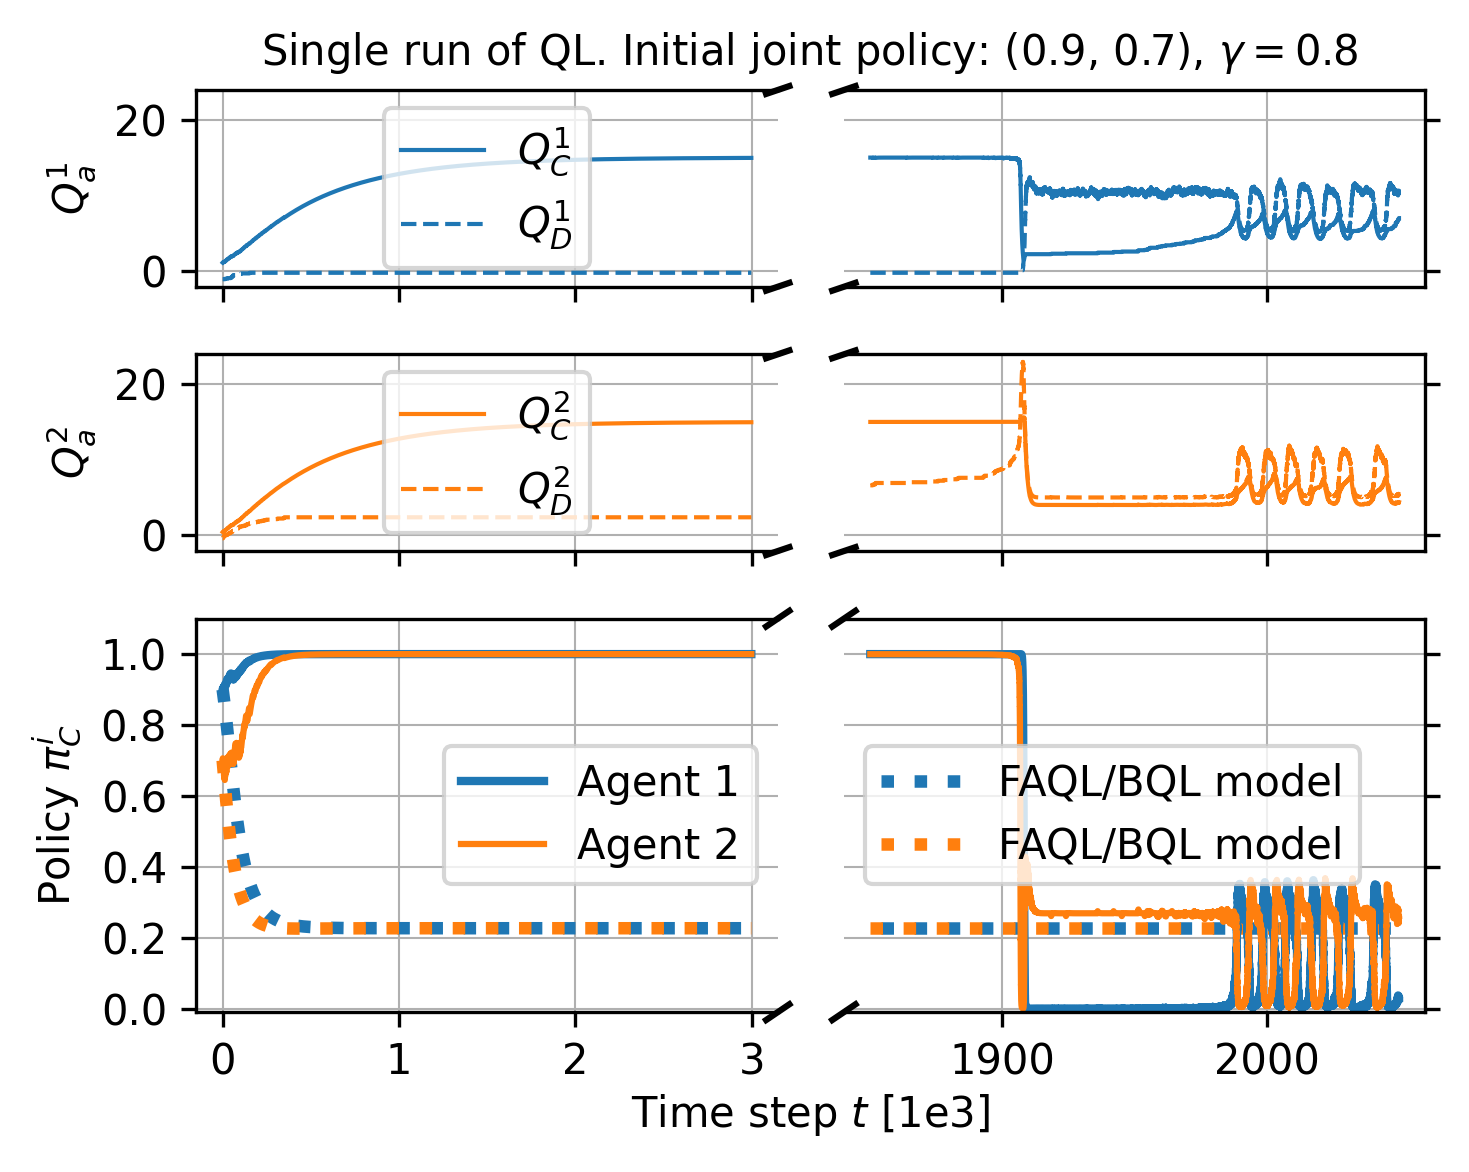

In [7]:
# FIGURE A
# plot Q-values over time
figsize=(5, 4)
fontsize = None
dpi=300
color1 = 'C0'
color2 = 'C1'
color_array = [color1, color2]
fig, ax = plt.subplots(3, 2, figsize=figsize, dpi=dpi, gridspec_kw={'height_ratios': [1, 1, 2]}, sharex='col', sharey='row')

# load the Q_table histories and the probabilities from files
initial_probability_pair = (0.9, 0.7)
temperature = 1
learning_rate = 0.01
discount_factor = 0.8

# Deterministic BATCH Q-learning agents
agent_pair = [DeterministicBatchAgent, DeterministicBatchAgent]
initial_q_tables_deterministic_agents = [generate_q_values_for_deterministic_agents(prob, temperature, base_value) for prob in initial_probability_pair]
agents_batch = [agent_pair[i](Q_values_initial = initial_q_tables_deterministic_agents[i],
                                       learning_rate=learning_rate, 
                                       discount_factor=discount_factor, 
                                       temperature=temperature) 
                                       for i in range(num_players)]
reward_matrices, game_title, first_action_title = get_individual_matrices(reward_matrix_for_two_player_PD)
for t in range(num_time_steps):
    deterministic_batch_Q_step(agents_batch, reward_matrices)
# get the histories of probabilities to cooperate for each agent 
n = 1 # plot only every n-th time step to reduce the number of lines
prob_coop_of_agent_batch_1_list = [vector[0] for vector in agents_batch[0].prob_vector_history[::n]]
prob_coop_of_agent_batch_2_list = [vector[0] for vector in agents_batch[1].prob_vector_history[::n]]

# load the Q_table histories and the probabilities from files
q_table_histories = np.load( os.path.join(directory, f"Q_table_histories_p_initial_{initial_probability_pair}_T_{temperature}_learningRate_{learning_rate}_y_{discount_factor}.npy"), allow_pickle=True)
probabilities_agents = np.load( os.path.join(directory, f"probabilities_p_initial_{initial_probability_pair}_T_{temperature}_learningRate_{learning_rate}_y_{discount_factor}.npy"), allow_pickle=True)
for i, agent in enumerate(agents):
    agent.q_table_history = q_table_histories[i]
max_time_steps = int(2.05e6)

x_range_1 = np.arange(0, int(3e3)-1)
x_range_2 = np.arange(int(1.85e6), max_time_steps)
loc="center" # change the location of the legend for the (0.9, 0.7) case where gamma = 0.8

# LEFT SIDE: first range
# FIGURE A
for i, agent in enumerate(agents):
    q_values_C_range_1 = [q_table[0, 0] for q_table in agent.q_table_history[x_range_1]]
    q_values_D_range_1 = [q_table[0, 1] for q_table in agent.q_table_history[x_range_1]]
    ax[i][0].plot(x_range_1, q_values_C_range_1, label=f'$Q^{i+1}_C$', color=color_array[i], linestyle='-', linewidth=1)
    ax[i][0].plot(x_range_1, q_values_D_range_1, label=f'$Q^{i+1}_D$', color=color_array[i], linestyle='--', linewidth=1)
    ax[i][0].set_ylabel(f'$Q^{i+1}'+r'_{a}$', fontsize=fontsize)
    ax[i][0].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[i][0].grid(linestyle='-', linewidth=0.5)
    ax[i][0].legend(loc=loc, fontsize=fontsize)

# calculate the range of the y-axis
y_range = [np.min(q_table_histories)-1, np.max(q_table_histories)+1]
print("y_range:" , y_range)
for i in range(2):
    ax[i][0].set_ylim(y_range)

# FIGURE B
# plot probabilities over time
handle1 = ax[2][0].plot(x_range_1, probabilities_agents[0][x_range_1], label=f'Agent 1', color=color1, zorder=10, linewidth=2)
handle2 = ax[2][0].plot(x_range_1, probabilities_agents[1][x_range_1], label=f'Agent 2', color=color2, zorder=10, linestyle='-')
# plot deterministic probabilities over time
if not Plot_just_simualtion:
    handle3 = ax[2][0].plot(x_range_1, np.array(prob_coop_of_agent_batch_1_list)[x_range_1], color=color1, zorder=5, linewidth=3, linestyle=':')
    handle4 = ax[2][0].plot(x_range_1, np.array(prob_coop_of_agent_batch_2_list)[x_range_1], color=color2, zorder=5, linewidth=3, linestyle=':')
# set labels
#ax[2][0].set_xlabel('Time step $t$ [1e3]', fontsize=fontsize)
ax[2][0].set_ylabel(f'Policy $\pi^i_C$', fontsize=fontsize)
# fix the y-axis to the range [-0.01, 1.1]
ax[2][0].set_ylim(-0.01, 1.1)
# Define a custom formatter to scale the x-axis labels by 1e3
round_length = 0
def scientific_formatter(x, pos):
    return f'{x / 1e3:.{round_length}f}'
# Set the custom formatter for the x-axis
ax[2][0].xaxis.set_major_formatter(FuncFormatter(scientific_formatter))
# set the ticks of the y-axis to be in steps of 0.2
ax[2][0].set_yticks(np.arange(0, 1.2, 0.2))
# title
#ax[0].set_title(f'Initial joint policy: {initial_probability_pair}, $\gamma = {discount_factor}$', fontsize=fontsize)
#caption = (f'$\gamma$ = {discount_factor}, '+r'$Q_{base}$ = '+f'{base_value}')
#fig.text(0.5, -0.05, caption, wrap=True, horizontalalignment='center', fontsize=fontsize)
if Plot_just_simualtion:
    ax[2][0].legend(loc="center", fontsize=fontsize)
else: 
    ax[2][0].legend(loc="center right", fontsize=fontsize)
ax[2][0].grid(linestyle='-', linewidth=0.5)

# RIGHT SIDE: second range
# FIGURE A
for i, agent in enumerate(agents):
    q_values_C_range_2 = [q_table[0, 0] for q_table in agent.q_table_history[x_range_2]]
    q_values_D_range_2 = [q_table[0, 1] for q_table in agent.q_table_history[x_range_2]]
    ax[i][1].plot(x_range_2, q_values_C_range_2, label=f'$Q^{i+1}_C$', color=color_array[i], linestyle='-', linewidth=1)
    ax[i][1].plot(x_range_2, q_values_D_range_2, label=f'$Q^{i+1}_D$', color=color_array[i], linestyle='--', linewidth=1)
    #ax[i][1].set_ylabel(f'$Q^{i+1}'+r'_{a}$', fontsize=fontsize)
    ax[i][1].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[i][1].grid(linestyle='-', linewidth=0.5)
# ensure that the y-axis is the same as on the left side
ax[0][1].set_ylim(y_range)
ax[1][1].set_ylim(y_range)
# FIGURE B
# plot deterministic probabilities over time
if not Plot_just_simualtion:
    ax[2][1].plot([min(x_range_2)+int(4e3), max(x_range_2)], [np.array(prob_coop_of_agent_batch_1_list)[-1], np.array(prob_coop_of_agent_batch_1_list)[-1]], color=color1, linestyle = ':', linewidth=3, label=f'FAQL/BQL model')
    ax[2][1].plot([min(x_range_2), max(x_range_2)], [np.array(prob_coop_of_agent_batch_2_list)[-1], np.array(prob_coop_of_agent_batch_2_list)[-1]], color=color2, linestyle = ':',  linewidth=3, label=f'FAQL/BQL model')
# plot probabilities over time
ax[2][1].plot(x_range_2, probabilities_agents[0][x_range_2], color=color1, linewidth=2)
ax[2][1].plot(x_range_2, probabilities_agents[1][x_range_2], color=color2, linestyle='-')
# set labels
ax[2][1].set_xlabel(' ', fontsize=fontsize)
#ax[2][1].set_ylabel(f'Policy $\pi^i_C$', fontsize=fontsize)
# fix the y-axis to the range [-0.01, 1.1]
ax[2][1].set_ylim(-0.01, 1.1)
# Define a custom formatter to scale the x-axis labels by 1e3
round_length = 0
def scientific_formatter(x, pos):
    return f'{x / 1e3:.{round_length}f}'
# Set the custom formatter for the x-axis
ax[2][1].xaxis.set_major_formatter(FuncFormatter(scientific_formatter))
if not Plot_just_simualtion:
    ax[2][1].legend(loc="center left", fontsize=fontsize)
ax[2][1].grid(linestyle='-', linewidth=0.5)

for i in range(3):
    # Hide the spines between the subplots
    ax[i][0].spines['right'].set_visible(False)
    ax[i][1].spines['left'].set_visible(False)
    ax[i][0].yaxis.tick_left()
    ax[i][1].yaxis.tick_right()

    # Add diagonal lines to indicate the break
    d = .02  # how big to make the diagonal lines in axes coordinates
    kwargs = dict(transform=ax[i][0].transAxes, color='k', clip_on=False)
    ax[i][0].plot((1-d, 1+d), (-d, +d), **kwargs)
    ax[i][0].plot((1-d, 1+d), (1-d, 1+d), **kwargs)
    kwargs.update(transform=ax[i][1].transAxes)  # switch to the right axes
    ax[i][1].plot((-d, +d), (-d, +d), **kwargs)
    ax[i][1].plot((-d, +d), (1-d, 1+d), **kwargs)

# Add a common x-axis label
fig.text(0.55, 0.05, 'Time step $t$ [1e3]', ha='center')

# title
ax[0][0].set_title(f' ', fontsize=fontsize)
if Plot_just_simualtion:
    fig.text(0.55, 0.935, f'Single run of QL. Initial joint policy: {initial_probability_pair}', fontsize=fontsize, ha='center')
else:
    fig.text(0.55, 0.935, f'Single run of QL. Initial joint policy: {initial_probability_pair}, $\gamma = {discount_factor}$', fontsize=fontsize, ha='center')

# save the figure
fig.tight_layout()
if Plot_just_simualtion:
    fig.savefig(f'Figures/PaperFigures/Fig1_SIMULATION_TimeEvolution_p_initial_{initial_probability_pair}_y={discount_factor}_T={temperature}_alpha={learning_rate}_time={max_time_steps}.pdf', dpi=dpi, bbox_inches='tight')
else:
    fig.savefig(f'Figures/PaperFigures/Fig1_TimeEvolution_p_initial_{initial_probability_pair}_y={discount_factor}_T={temperature}_alpha={learning_rate}_time={max_time_steps}.pdf', dpi=dpi, bbox_inches='tight')
fig.show()

# Deterministic Plots

Initial probabilities: [0.5, 0.48]


/var/folders/m0/6bzh86rj63g58k6l_qqv_3z80000gn/T/ipykernel_23651/3820850607.py:105: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


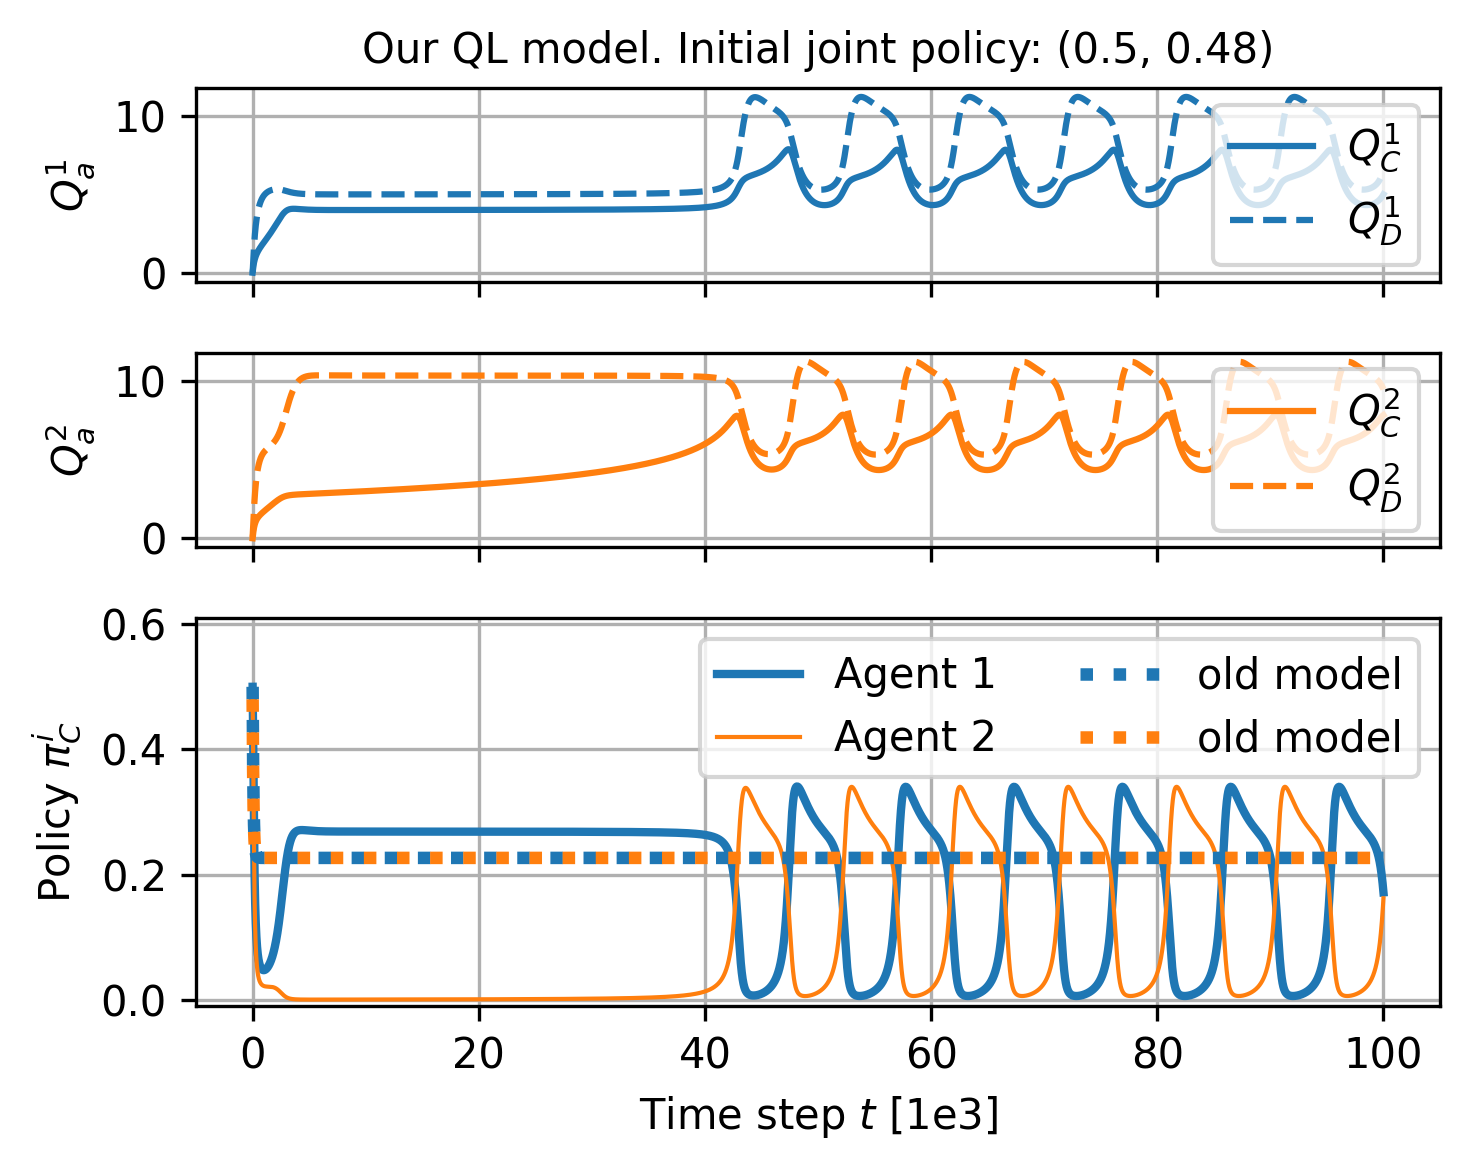

In [8]:
# Enable inline plotting
%matplotlib inline
dpi = 300
figsize = (5,4)

reward_function = reward_matrix_for_two_player_PD
reward_matrices, game_title, first_action_title = get_individual_matrices(reward_function)

# Define the parameters
learning_rate = 0.01
discount_factor = 0.8 # Bifurcation at 0.745675... and 0.954936228028...
temperature = 1

# Define base value around which the Q-values are centered if given initial probabilities
base_value = 0
num_time_steps = int(1e5)

# define the initial Q-values
initial_probability_pair = (0.5, 0.48)
Q_values_initial_list = [generate_q_values_for_deterministic_agents(prob, temperature, base_value) for prob in initial_probability_pair]
#Q_values_initial_list = [np.array([0, 0], dtype=float), np.array([0, 0.1], dtype=float)]
# print the resulting initial probabilities
initial_probability_pair = [np.exp(Q_values_initial[0] / temperature) / np.sum(np.exp(Q_values_initial / temperature)) for Q_values_initial in Q_values_initial_list]
print("Initial probabilities:", initial_probability_pair)

# run deterministic Q-learning model
agents = [DeterministicAgent(Q_values_initial, learning_rate, discount_factor, temperature) for Q_values_initial in Q_values_initial_list]
for time_step in range(num_time_steps):
    Q_step(agents, reward_matrices)

# run deterministic BATCH Q-learning agents
agent_pair = [DeterministicBatchAgent, DeterministicBatchAgent]
initial_q_tables_deterministic_agents = [generate_q_values_for_deterministic_agents(prob, temperature, base_value) for prob in initial_probability_pair]
agents_batch = [agent_pair[i](Q_values_initial = initial_q_tables_deterministic_agents[i],
                                       learning_rate=learning_rate, 
                                       discount_factor=discount_factor, 
                                       temperature=temperature) 
                                       for i in range(num_players)]
reward_matrices, game_title, first_action_title = get_individual_matrices(reward_matrix_for_two_player_PD)
for t in range(num_time_steps):
    deterministic_batch_Q_step(agents_batch, reward_matrices)
# get the histories of probabilities to cooperate for each agent 
n = 1 # plot only every n-th time step to reduce the number of lines
prob_coop_of_agent_batch_1_list = [vector[0] for vector in agents_batch[0].prob_vector_history[::n]]
prob_coop_of_agent_batch_2_list = [vector[0] for vector in agents_batch[1].prob_vector_history[::n]]

# plot dynamics in Q-space
linestyle_array = ['-', '--']
linewidth_array = [2, 1]
color_array = ['C0', 'C1']

fig, ax = plt.subplots(3, 1, figsize=figsize, dpi=dpi, sharex=True, gridspec_kw={'height_ratios': [1, 1, 2]})

# plot Q-values over time for each agent seperate
for i, agent in enumerate(agents):
    color = color_array[i]
    ax[i].plot(np.arange(num_time_steps), np.array(agent.Q_values_history)[:, 0], label=f'$Q^{i+1}_C$', linestyle=linestyle_array[0], color=color)
    ax[i].plot(np.arange(num_time_steps), np.array(agent.Q_values_history)[:, 1], label=f'$Q^{i+1}_D$', linestyle=linestyle_array[1], color=color)
    #plt.scatter(num_time_steps, agent.prob_vector_history[-1][0], marker="x", label=f'final prob. to coop. of {i+1}: {agent.prob_vector_history[-1][0]:.3f}')
    # use scientific notation for the x-axis
    ax[i].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    ax[i].set_ylabel(f'$Q^{i+1}_a$')
    ax[i].legend(loc="center right")
    ax[i].grid()

# identify which range is larger
y_range_0 = ax[0].get_ylim()
y_range_1 = ax[1].get_ylim()
# get the minimum and the maximum
y_range = [min(y_range_0[0], y_range_1[0]), max(y_range_0[1], y_range_1[1])]
for i in range(2):
    ax[i].set_ylim(y_range)
    
# plot QL dynamics in policy-space
for i, agent in enumerate(agents):
    ax[2].plot(np.arange(num_time_steps), np.array(agent.prob_vector_history)[:, 0], label=f'Agent {i+1}', linewidth=linewidth_array[i], color=color_array[i])

# plot batch QL dynamics in policy-space
for i, agent_batch in enumerate(agents_batch):
    #ax[2].plot(np.arange(num_time_steps), np.array(agent_batch.prob_vector_history)[:, 0], label=f'FAQL/BQL model', linestyle=':', linewidth=3, color=color_array[i])
    ax[2].plot(np.arange(num_time_steps), np.array(agent_batch.prob_vector_history)[:, 0], label=f'old model', linestyle=':', linewidth=3, color=color_array[i])

# Define a custom formatter to scale the x-axis labels by 1e3
def scientific_formatter(x, pos):
    return f'{x / 1e3:.{round_length}f}'
# Set the custom formatter for the x-axis
ax[2].xaxis.set_major_formatter(FuncFormatter(scientific_formatter))
# set labels
ax[2].set_xlabel('Time step $t$ [1e3]', fontsize=fontsize)
ax[2].set_ylabel(f'Policy $\pi^i_C$', fontsize=fontsize)
ax[2].legend(loc="upper right", ncol=2)
ax[2].grid()

# fix the y-axis to the range
ax[2].set_ylim(-0.01, 0.61)
if initial_probability_pair == (0.9, 0.7):
    ax[2].set_ylim(-0.01, 1.1)
    ax[2].set_yticks(np.arange(0, 1.2, 0.2))

# title
ax[0].set_title(f'Our QL model. Initial joint policy: ({initial_probability_pair[0]:.1f}, {initial_probability_pair[1]:.2f})', fontsize=fontsize)
# save the figure
fig.tight_layout()
#fig.savefig(f'Figures/PaperFigures/Fig1_MODEL_TimeEvolution_p_initial_({initial_probability_pair[0]:.2f},{initial_probability_pair[1]:.2f})_y={discount_factor}_T={temperature}_alpha={learning_rate}_time={num_time_steps}.pdf', dpi=dpi, bbox_inches='tight')
fig.show()

In [9]:
# load the Q_table histories and the probabilities from files
initial_probability_pair = (0.9, 0.7)
temperature = 1
learning_rate = 0.01
discount_factor = 0.8
# Define base value around which the Q-values are centered if given initial probabilities
base_value = 0
num_time_steps = int(2.05e6)

# define the initial Q-values
Q_values_initial_list = [generate_q_values_for_deterministic_agents(prob, temperature, base_value) for prob in initial_probability_pair]
print("Initial Q-values:", Q_values_initial_list)
# run deterministic Q-learning model
agents = [DeterministicAgent(Q_values_initial, learning_rate, discount_factor, temperature) for Q_values_initial in Q_values_initial_list]
for time_step in range(num_time_steps):
    Q_step(agents, reward_matrices)

# Deterministic BATCH Q-learning agents
num_time_steps_for_batch_QL = int(3e3)
agent_pair = [DeterministicBatchAgent, DeterministicBatchAgent]
initial_q_tables_deterministic_agents = [generate_q_values_for_deterministic_agents(prob, temperature, base_value) for prob in initial_probability_pair]
agents_batch = [agent_pair[i](Q_values_initial = initial_q_tables_deterministic_agents[i],
                                       learning_rate=learning_rate, 
                                       discount_factor=discount_factor, 
                                       temperature=temperature) 
                                       for i in range(num_players)]
reward_matrices, game_title, first_action_title = get_individual_matrices(reward_matrix_for_two_player_PD)
for t in range(num_time_steps_for_batch_QL):
    deterministic_batch_Q_step(agents_batch, reward_matrices)
# get the histories of probabilities to cooperate for each agent 
n = 1 # plot only every n-th time step to reduce the number of lines
prob_coop_of_agent_batch_1_list = [vector[0] for vector in agents_batch[0].prob_vector_history[::n]]
prob_coop_of_agent_batch_2_list = [vector[0] for vector in agents_batch[1].prob_vector_history[::n]]

Initial Q-values: [array([ 1.09861229, -1.09861229]), array([ 0.42364893, -0.42364893])]


y_range: [-2.0986122886681096, 23.94941957731441]


/var/folders/m0/6bzh86rj63g58k6l_qqv_3z80000gn/T/ipykernel_23651/216507153.py:120: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


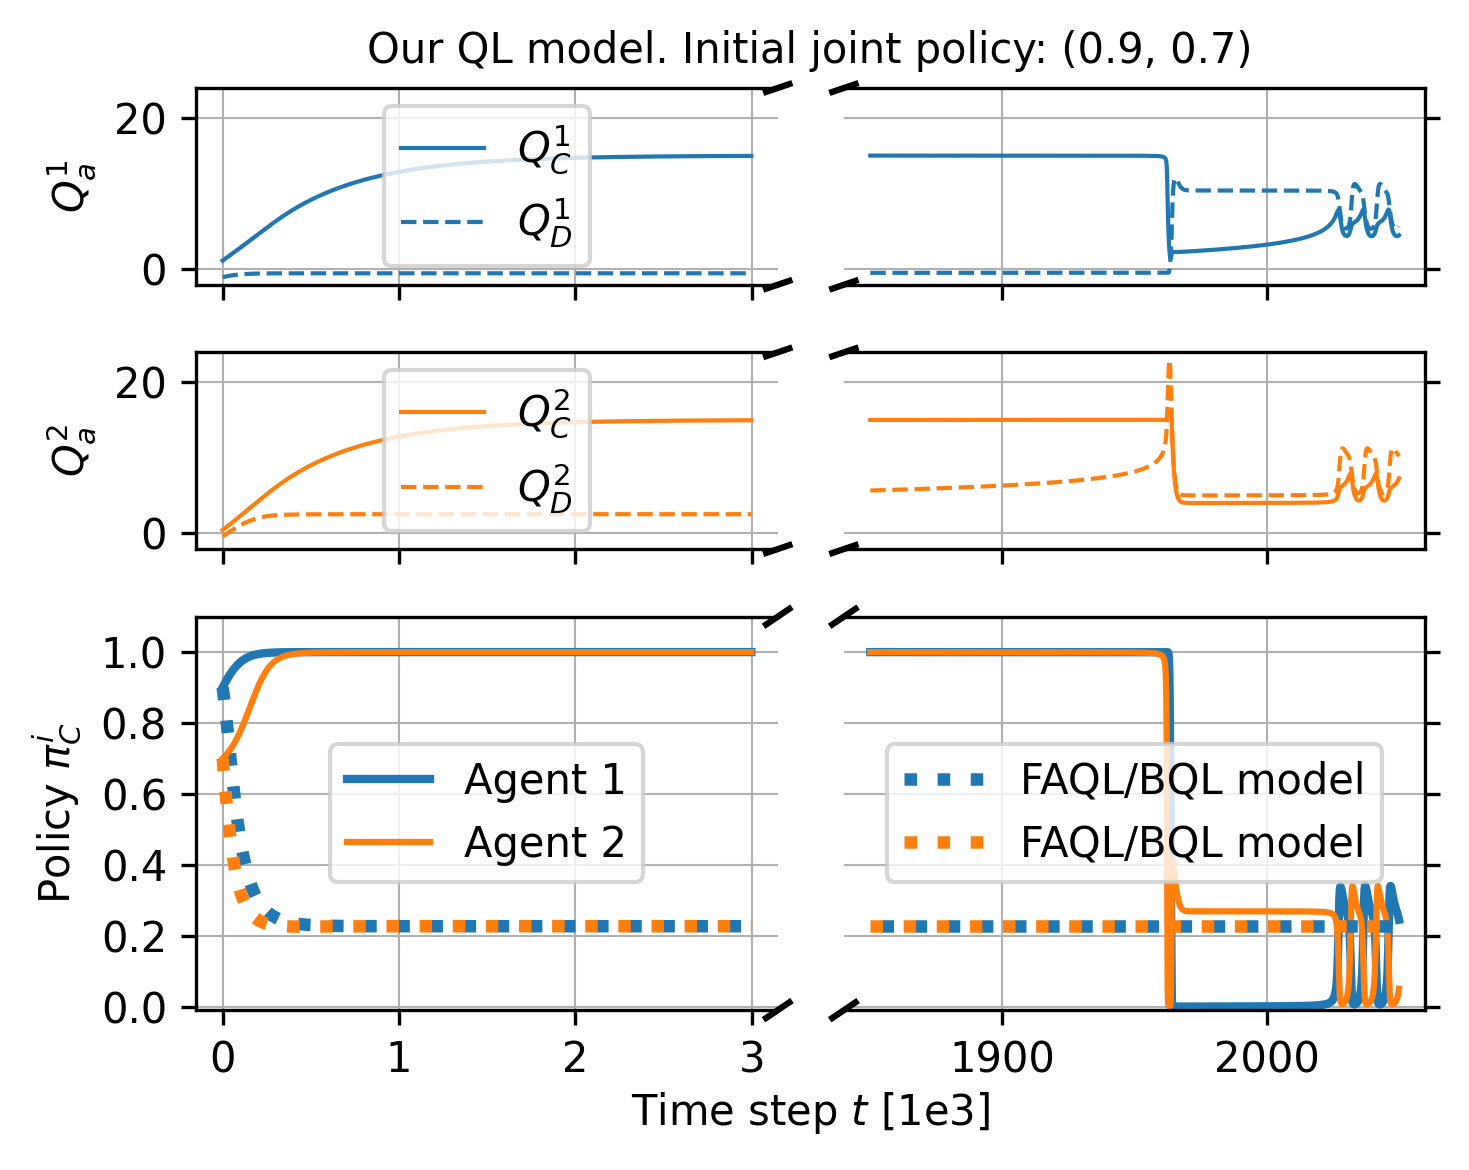

In [10]:
figsize=(5, 4)
fontsize = None
dpi=300
color1 = 'C0'
color2 = 'C1'
color_array = [color1, color2]
fig, ax = plt.subplots(3, 2, figsize=figsize, dpi=dpi, gridspec_kw={'height_ratios': [1, 1, 2]}, sharex='col', sharey='row')

x_range_1 = np.arange(0, int(3e3)-1)
x_range_2 = np.arange(int(1.85e6), max_time_steps)
loc="center" # change the location of the legend for the (0.9, 0.7) case where gamma = 0.8
linewidth  = 3

# LEFT SIDE: first range
# FIGURE A
for i, agent in enumerate(agents):
    q_values_C_range_1 = np.array(agent.Q_values_history)[x_range_1, 0]
    q_values_D_range_1 = np.array(agent.Q_values_history)[x_range_1, 1]
    ax[i][0].plot(x_range_1, q_values_C_range_1, label=f'$Q^{i+1}_C$', color=color_array[i], linestyle='-', linewidth=1)
    ax[i][0].plot(x_range_1, q_values_D_range_1, label=f'$Q^{i+1}_D$', color=color_array[i], linestyle='--', linewidth=1)
    ax[i][0].set_ylabel(f'$Q^{i+1}'+r'_{a}$', fontsize=fontsize)
    ax[i][0].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[i][0].grid(linestyle='-', linewidth=0.5)
    ax[i][0].legend(loc=loc, fontsize=fontsize)

# calculate the range of the y-axis
y_range = [np.min(q_table_histories)-1, np.max(q_table_histories)+1]
print("y_range:" , y_range)
for i in range(2):
    ax[i][0].set_ylim(y_range)

# FIGURE B
# plot probabilities over time
handle1 = ax[2][0].plot(x_range_1, np.array(agents[0].prob_vector_history)[x_range_1, 0], label=f'Agent 1', color=color1, zorder=10, linewidth=2)
handle2 = ax[2][0].plot(x_range_1, np.array(agents[1].prob_vector_history)[x_range_1, 0], label=f'Agent 2', color=color2, zorder=10, linestyle='-')
# plot deterministic batch probabilities over time
handle3 = ax[2][0].plot(x_range_1, np.array(prob_coop_of_agent_batch_1_list)[x_range_1], color=color1, zorder=5, linewidth=linewidth, linestyle=':')
handle4 = ax[2][0].plot(x_range_1, np.array(prob_coop_of_agent_batch_2_list)[x_range_1], color=color2, zorder=5, linewidth=linewidth, linestyle=':')
# set labels
#ax[2][0].set_xlabel('Time step $t$ [1e3]', fontsize=fontsize)
ax[2][0].set_ylabel(f'Policy $\pi^i_C$', fontsize=fontsize)
# fix the y-axis to the range [-0.01, 1.1]
ax[2][0].set_ylim(-0.01, 1.1)
# Define a custom formatter to scale the x-axis labels by 1e3
round_length = 0
def scientific_formatter(x, pos):
    return f'{x / 1e3:.{round_length}f}'
# Set the custom formatter for the x-axis
ax[2][0].xaxis.set_major_formatter(FuncFormatter(scientific_formatter))
# set the ticks of the y-axis to be in steps of 0.2
ax[2][0].set_yticks(np.arange(0, 1.2, 0.2))
# title
#ax[0].set_title(f'Initial joint policy: {initial_probability_pair}, $\gamma = {discount_factor}$', fontsize=fontsize)
#caption = (f'$\gamma$ = {discount_factor}, '+r'$Q_{base}$ = '+f'{base_value}')
#fig.text(0.5, -0.05, caption, wrap=True, horizontalalignment='center', fontsize=fontsize)
ax[2][0].legend(loc="center", fontsize=fontsize)
ax[2][0].grid(linestyle='-', linewidth=0.5)

# RIGHT SIDE: second range
# FIGURE A
for i, agent in enumerate(agents):
    q_values_C_range_2 = np.array(agent.Q_values_history)[x_range_2, 0]
    q_values_D_range_2 = np.array(agent.Q_values_history)[x_range_2, 1]
    ax[i][1].plot(x_range_2, q_values_C_range_2, label=f'$Q^{i+1}_C$', color=color_array[i], linestyle='-', linewidth=1)
    ax[i][1].plot(x_range_2, q_values_D_range_2, label=f'$Q^{i+1}_D$', color=color_array[i], linestyle='--', linewidth=1)
    #ax[i][1].set_ylabel(f'$Q^{i+1}'+r'_{a}$', fontsize=fontsize)
    ax[i][1].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[i][1].grid(linestyle='-', linewidth=0.5)
# ensure that the y-axis is the same as on the left side
ax[0][1].set_ylim(y_range)
ax[1][1].set_ylim(y_range)
# FIGURE B
# plot probabilities over time
ax[2][1].plot(x_range_2, np.array(agents[0].prob_vector_history)[x_range_2, 0], color=color1, linewidth=2)
ax[2][1].plot(x_range_2, np.array(agents[1].prob_vector_history)[x_range_2, 0], color=color2, linestyle='-')
# plot deterministic batch probabilities over time
ax[2][1].plot([min(x_range_2)+int(4e3), max(x_range_2)], [np.array(prob_coop_of_agent_batch_1_list)[-1], np.array(prob_coop_of_agent_batch_1_list)[-1]], color=color1, linestyle = ':', linewidth=linewidth, label=f'FAQL/BQL model')
ax[2][1].plot([min(x_range_2), max(x_range_2)], [np.array(prob_coop_of_agent_batch_2_list)[-1], np.array(prob_coop_of_agent_batch_2_list)[-1]], color=color2, linestyle = ':',  linewidth=linewidth, label=f'FAQL/BQL model')
# set labels
ax[2][1].set_xlabel(' ', fontsize=fontsize)
#ax[2][1].set_ylabel(f'Policy $\pi^i_C$', fontsize=fontsize)
# fix the y-axis to the range [-0.01, 1.1]
ax[2][1].set_ylim(-0.01, 1.1)
# Define a custom formatter to scale the x-axis labels by 1e3
round_length = 0
def scientific_formatter(x, pos):
    return f'{x / 1e3:.{round_length}f}'
# Set the custom formatter for the x-axis
ax[2][1].xaxis.set_major_formatter(FuncFormatter(scientific_formatter))
ax[2][1].legend(loc="center", fontsize=fontsize)
ax[2][1].grid(linestyle='-', linewidth=0.5)

for i in range(3):
    # Hide the spines between the subplots
    ax[i][0].spines['right'].set_visible(False)
    ax[i][1].spines['left'].set_visible(False)
    ax[i][0].yaxis.tick_left()
    ax[i][1].yaxis.tick_right()

    # Add diagonal lines to indicate the break
    d = .02  # how big to make the diagonal lines in axes coordinates
    kwargs = dict(transform=ax[i][0].transAxes, color='k', clip_on=False)
    ax[i][0].plot((1-d, 1+d), (-d, +d), **kwargs)
    ax[i][0].plot((1-d, 1+d), (1-d, 1+d), **kwargs)
    kwargs.update(transform=ax[i][1].transAxes)  # switch to the right axes
    ax[i][1].plot((-d, +d), (-d, +d), **kwargs)
    ax[i][1].plot((-d, +d), (1-d, 1+d), **kwargs)

# Add a common x-axis label
fig.text(0.55, 0.05, 'Time step $t$ [1e3]', ha='center')

# title
ax[0][0].set_title(f' ', fontsize=fontsize)
fig.text(0.55, 0.935, f'Our QL model. Initial joint policy: {initial_probability_pair}', fontsize=fontsize, ha='center')

# save the figure
fig.tight_layout()
if True:
    fig.savefig(f'Figures/PaperFigures/Fig1_MODEL_TimeEvolution_p_initial_{initial_probability_pair}_y={discount_factor}_T={temperature}_alpha={learning_rate}_time={num_time_steps}.pdf', dpi=dpi, bbox_inches='tight')
fig.show()